In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import mpl

In [105]:
def write2excel(df,savepath,sheet_name):
    """
    将数据写入已存在的 excel 表
    df：DataFrame
    savepath：excel 所在的路径
    sheet_name：表格名
    """
    import openpyxl

    wb = openpyxl.load_workbook(savepath)
    #如果有多个模块可以读写excel文件，这里要指定engine，否则可能会报错
    writer = pd.ExcelWriter(savepath,engine='openpyxl')
    #没有下面这个语句的话excel表将完全被覆盖
    writer.book = wb

    #如果有相同名字的工作表，新添加的将命名为Sheet21，如果Sheet21也有了就命名为Sheet22，不会覆盖原来的工作表
    df.to_excel(writer,sheet_name = sheet_name)
    writer.save()
    writer.close()

In [106]:
# 20220729更新
def df_describe(df):
    """
    得出描述性统计
    :df: 接收 pandas.DataFrame 数据格式
    """      
    des = df.describe().T # 初步的描述性统计结果
    des["CV"] = 100 * des["std"]/ des["mean"] # 计算变异系数
    des = des.drop(["25%","75%"],axis=1) # 删掉四分位点
    
    skew = pd.DataFrame(df.skew(),columns={"skew"}) # 偏度计算
    kurt = pd.DataFrame(df.kurt(),columns={"kurt"}) # 峰度计算
    sk = pd.concat([skew,kurt],axis=1)
    
    des_final = pd.concat([des,sk],axis=1)
    
    des_final.columns = ["样本数","均值","标准差",
                   "最小值","中位数","最大值","变异系数 CV（%）",
                  "偏度","峰度"] # 进行中文命名
    
    return des_final

In [107]:
def optimize_k(data,target,number):
    """
    用 KNN 填充缺失时选择最佳 K 值
    data: 接收 pandas.DataFrame 数据格式
    target: 用来当作因变量的变量
    number: N 的最大取值
    """   
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error
    from sklearn.impute import KNNImputer
    
    rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

    errors = []
    for k in range(1, number, 1):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=data.columns)
        
        X = df_imputed.drop(target, axis=1)
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds)
        errors.append({'K': k, 'RMSE': error})
        
    return errors

In [108]:
def data_standard(data):
    """
    标准化数据：减去均值再除以标准差
    data：有 index 的 DataFrame
    """  
    from sklearn.preprocessing import scale
    data_scaled = scale(data)
    data_scaled = pd.DataFrame(data_scaled, columns=data.columns,index=data.index)
    
    return data_scaled

In [175]:
def data_normalize(data):
    """
    标准化数据：减去均值再除以标准差
    data：有 index 的 DataFrame
    """     
    from sklearn.preprocessing import normalize
    data_scaled = normalize(data)
    data_scaled = pd.DataFrame(data_scaled, columns=data.columns,index=data.index)
    
    return data_scaled

In [109]:
# task 1 ： 查看离群点
# 箱线图

In [110]:
def plt_config():
    """
    设置画图的参数，包括字体、字号等
    """  
    config = {
        "font.family": "serif",  # 使用衬线体
        "font.serif": ["SimHei"],  # 中易黑体
        "font.size": 25,  # 字号
        "axes.unicode_minus": False, #  # 解决保存图像负号'-'显示为方块的问题
        "mathtext.fontset": "stix",  # 设置 LaTeX 字体，stix 近似于 Times 字体
        }
    plt.rcParams.update(config)

In [111]:
def save_boxplot(df,eng,filepath):
    """
    绘制数据框每一列的箱线图
    df: 接收 pandas.DataFrame 数据格式，没有索引，每一列均为变量
    filepath: 保存图片的文件夹路径，以斜杠结尾
    """  
    plt_config() # 设置画图的全局参数
    
    cols = df.columns.tolist()  # 画图
    for col in cols:
        sns.boxplot(col,data=df,palette="Set2",showfliers=False)
        sns.swarmplot(col,data=df,color=sns.color_palette("Set2")[1])
        

        t1 = eng.loc[col,"性状无单位"] # 标题三部分之一：性状，如株高
        t2 = eng.loc[col,"单位数学格式"] # 标题三部分之二：单位，格式为 $(cm)$
        t3 = eng.loc[col,"英文全称数学格式"] # 标题三部分之三：英文全称，格式为 $\mathrm{Plant\ height}$
        
        if col == "大小维管束平均面积比值":
            title = t1 + "\n" + t3 # 特殊情况，性状没有单位
        else:              
            title = t1 + t2 + "\n" + t3 # 一般情况性状都有单位
            
        plt.title(title) # 添加标题
        plt.xlabel(None) # 去掉 xlabel
        plt.xticks(fontproperties="Times new roman") # 设置 ticks 字体为 Times new roman
        
        col = col.replace('/', 'sub') # 把性状名中的斜杠换成英文，以免被系统认为是路径
        savepath = filepath + col + ".png" 
        plt.savefig(savepath, bbox_inches = 'tight') # 保存图片

        plt.show() # 显示图片

In [112]:
wd = "/Users/sherlock/Documents/bioinformatics/维管束/" # 设定工作路径

In [113]:
# 所有性状
filepath = wd + "高粱数据20220718.xlsx"
data = pd.read_excel(filepath,sheet_name="4.4")
data.head(2)

,样本编号,品种编号,品种名称,来源,备注,空腔面积(mm²),茎直径(mm),茎周长(mm),去腔茎面积(mm²),大维管束数目(No.),...,小维管束相对离心距(%),小维管束“周长密度”(No./mm),小维管束“面积密度”(No./mm²),大维管束“面积密度”(No./mm²),株高(cm),株重(g),穗长(cm),穗重(g),一次枝梗数(No.),百粒重(g)
0,NN2/L45,L45,GW000385,印度,NaN,0.0,8.739130,26.968989,56.982278,182,...,93.790503,7.453004,47.658484,3.449271,121.333333,206.2,24.333333,20.0,41.2,2.3213
1,NN2/L25,L25,V-9,贵州本地,侧散、伞型,0.0,7.217391,22.207757,38.522474,134,...,92.938364,7.745042,54.009934,3.791965,129.000000,157.0,41.000000,51.4,42.2,1.9418


In [114]:
df = data.iloc[:,5:]
df.head(2)

,空腔面积(mm²),茎直径(mm),茎周长(mm),去腔茎面积(mm²),大维管束数目(No.),小维管束数目(No.),总维管束数目(No.),大维管束平均面积(mm²),小维管束平均面积(mm²),大维管束离心距(mm),...,小维管束相对离心距(%),小维管束“周长密度”(No./mm),小维管束“面积密度”(No./mm²),大维管束“面积密度”(No./mm²),株高(cm),株重(g),穗长(cm),穗重(g),一次枝梗数(No.),百粒重(g)
0,0.0,8.739130,26.968989,56.982278,182,201,383,0.031374,0.019992,3.070015,...,93.790503,7.453004,47.658484,3.449271,121.333333,206.2,24.333333,20.0,41.2,2.3213
1,0.0,7.217391,22.207757,38.522474,134,172,306,0.020019,0.012907,2.374729,...,92.938364,7.745042,54.009934,3.791965,129.000000,157.0,41.000000,51.4,42.2,1.9418


In [53]:
eng = pd.read_excel("../data/性状表.xlsx",sheet_name="性状中英文名")
eng.head(2)

,性状,性状无单位,单位一般格式,单位数学格式,英文全称,英文全称数学格式,英文适中长度数学格式,英文较短长度数学格式,英文简称
0,株高(cm),株高,(cm),$(cm)$,Plant height,$\mathrm{Plant\ height}$,$\mathrm{Plant\ height}$,$\mathrm{Plant\ height}$,PH
1,株重(g),株重,(g),$(g)$,Plant weight,$\mathrm{Plant\ weight}$,$\mathrm{Plant\ weight}$,$\mathrm{Plant\ weight}$,PW


In [54]:
eng = eng.set_index("性状")

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


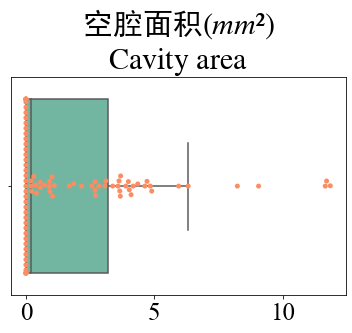

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


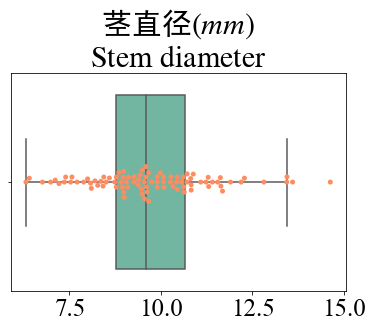

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


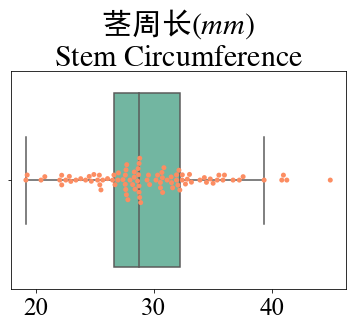

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


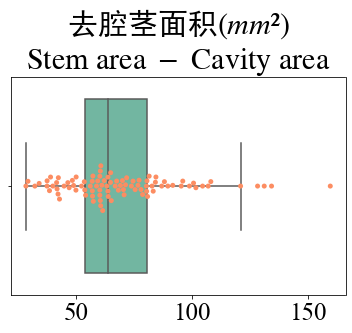

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


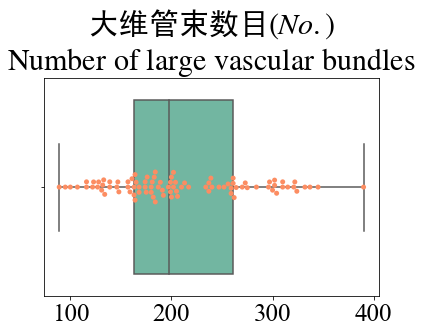

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


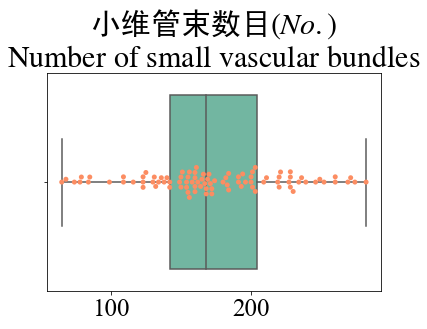

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


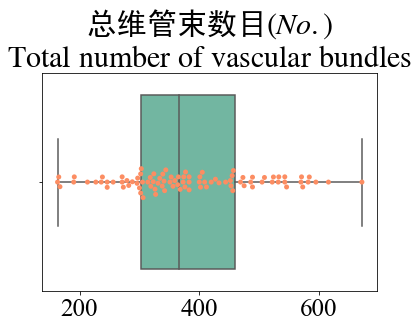

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


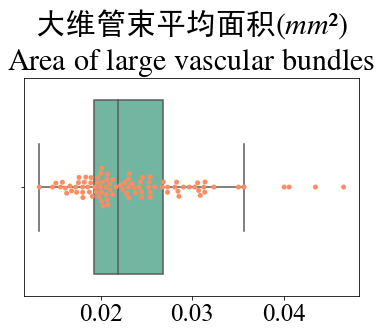

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


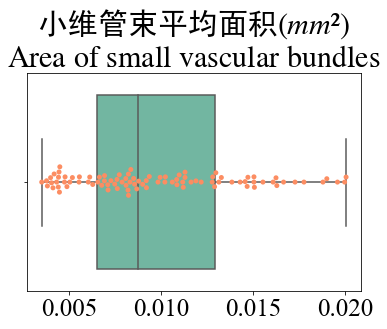

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


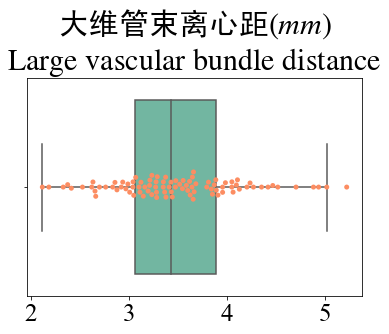

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


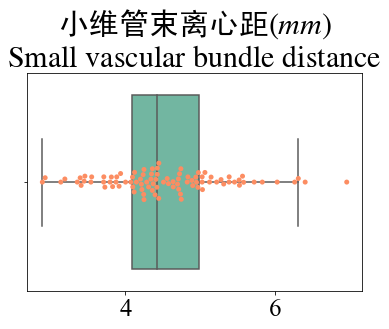

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 13.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


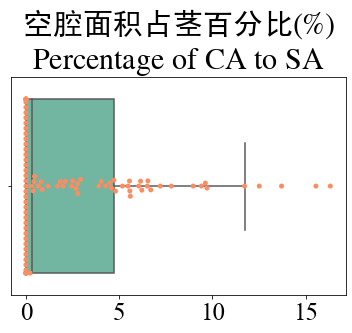

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


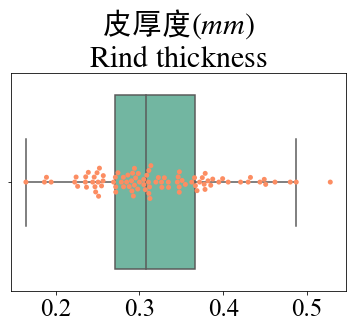

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


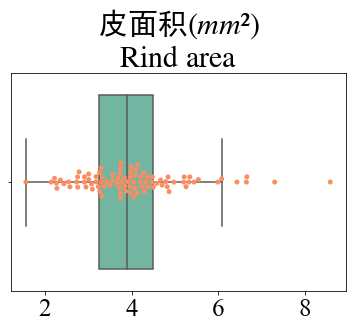

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


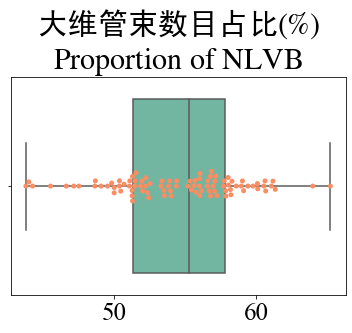

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


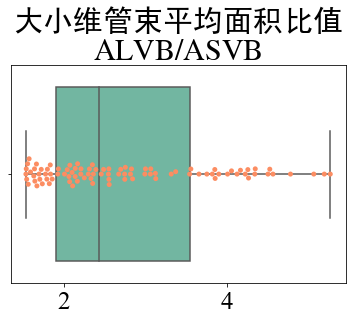

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


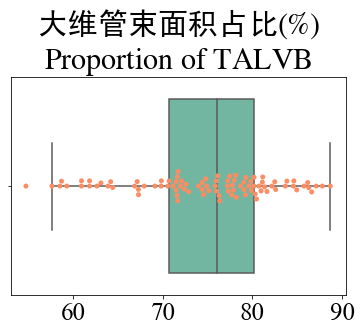

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


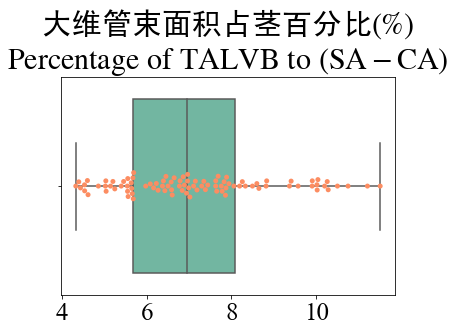

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


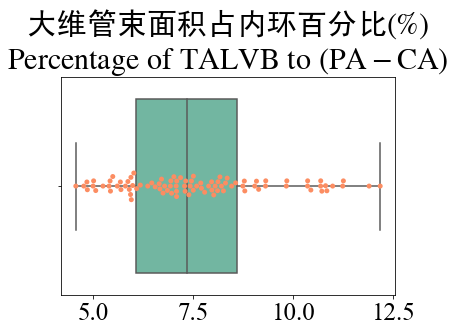

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


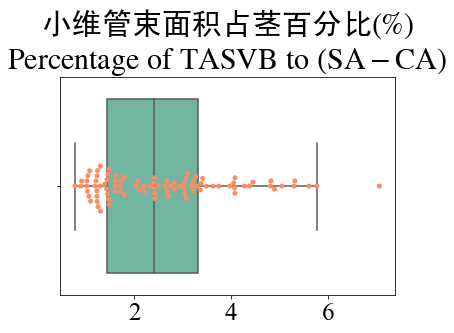

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


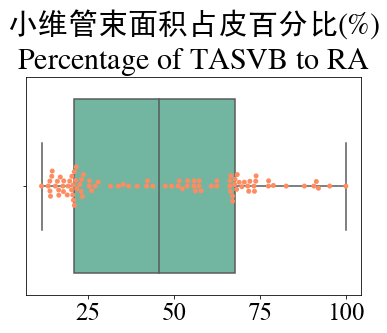

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


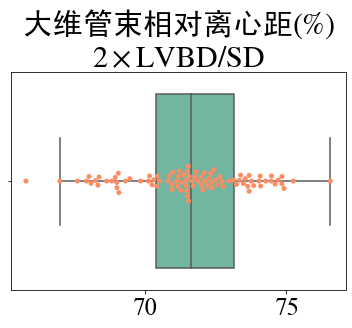

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


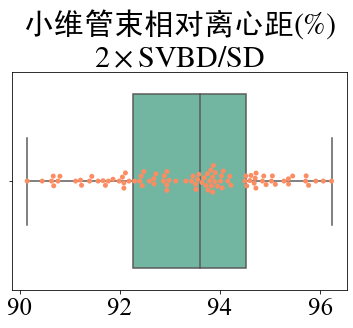

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


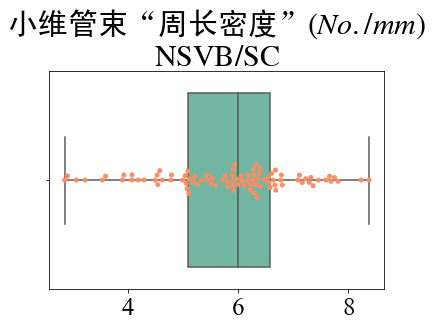

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


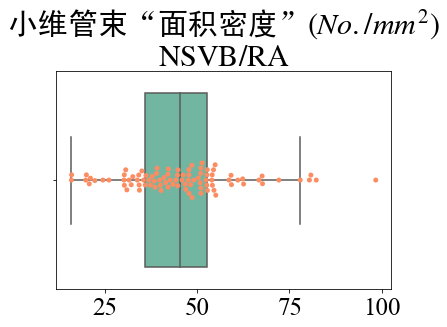

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


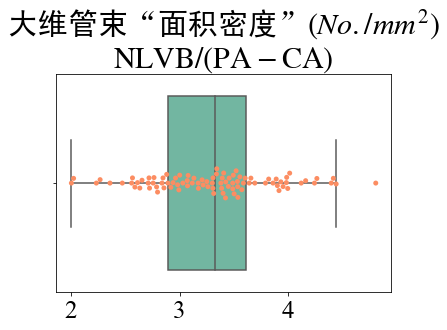

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


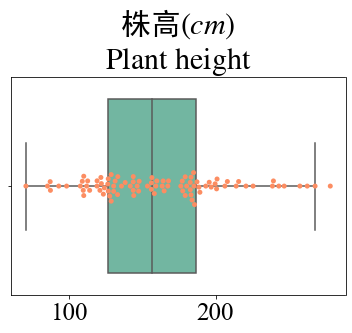

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


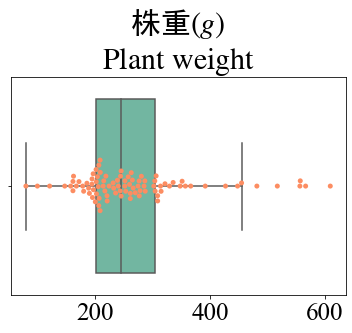

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


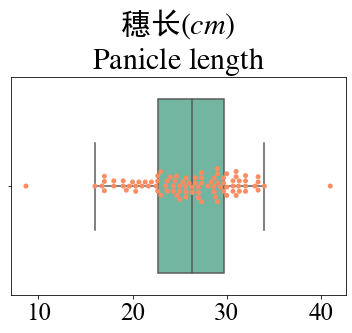

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


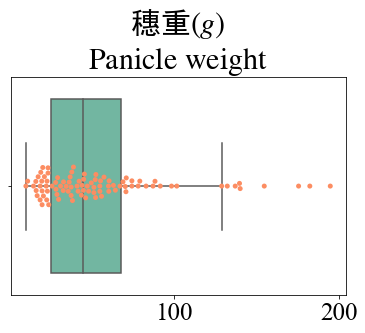

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


KeyError: '一次枝梗数(No.)'

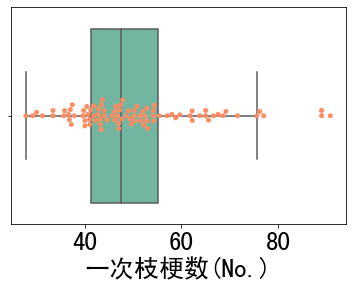

In [77]:
filepath = wd + "陆分析结果/boxplot/"
save_boxplot(df,eng,filepath)

In [ ]:
# task 2 ： 查看数据分布
# 直方图

In [68]:
def save_histgram(df,eng,filepath):  
    """
    绘制数据框每一列的直方图
    df: 接收 pandas.DataFrame 数据格式，没有索引，每一列均为变量
    eng: 性状表，包括性状对应的单位、英文全称、英文简称
    filepath: 保存图片的文件夹路径，以斜杠结尾
    """  
    plt_config() # 设置画图的全局参数
    from matplotlib.font_manager import FontProperties # 设置字体的函数

    cols = df.columns.tolist() # 画图
    for col in cols:
        sns.rugplot(df[col],color="k")
        plt.hist(df[col], facecolor = "w",edgecolor="k")


        t1 = eng.loc[col,"性状无单位"] # 标题三部分之一：性状，如株高
        t2 = eng.loc[col,"单位数学格式"] # 标题三部分之二：单位，格式为 $(cm)$
        t3 = eng.loc[col,"英文全称数学格式"] # 标题三部分之三：英文全称，格式为 $\mathrm{Plant\ height}$
        
        if col == "大小维管束平均面积比值":
            title = t1 + "\n" + t3 # 特殊情况，性状没有单位
        else:              
            title = t1 + t2 + "\n" + t3 # 一般情况性状都有单位
            
        plt.title(title) # 添加标题
    
        plt.xlabel(None) # 去掉 xlabel
        plt.xticks(fontproperties="Times new roman") # 设置 ticks 字体为 Times new roman
        plt.yticks(fontproperties="Times new roman")
       
        col = col.replace('/', 'sub')
        savepath = filepath + col + ".pdf" 
        plt.savefig(savepath, bbox_inches = 'tight') # 保存图片

        plt.show() # 展示图片

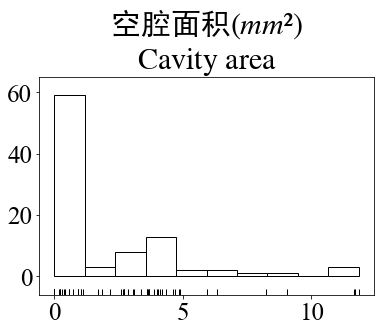

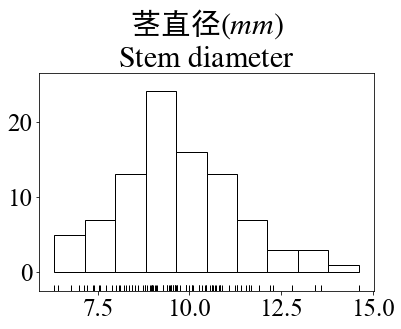

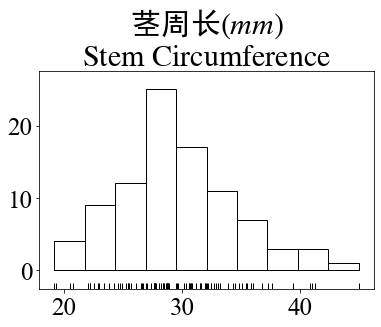

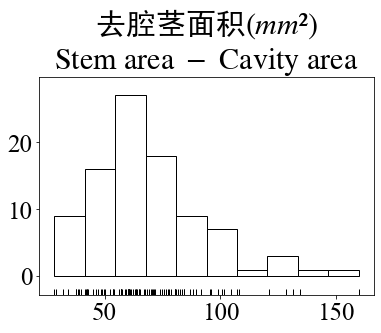

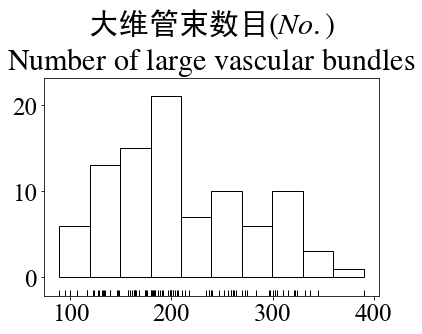

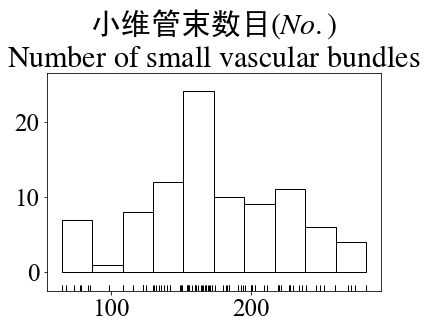

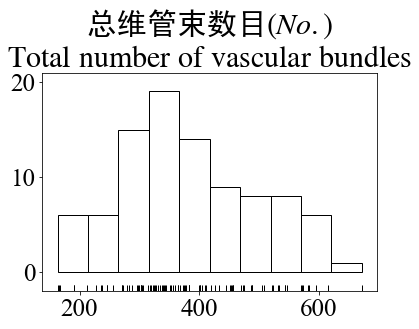

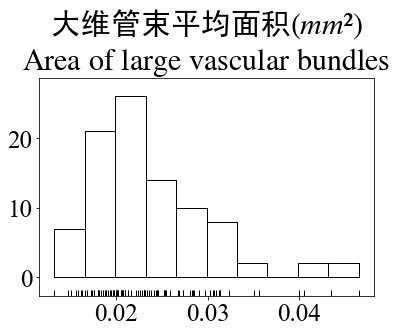

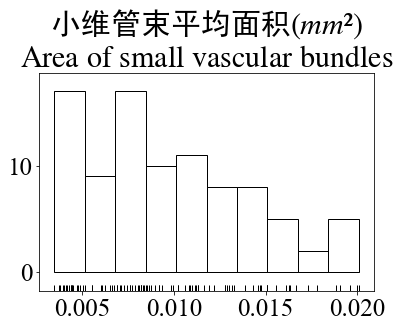

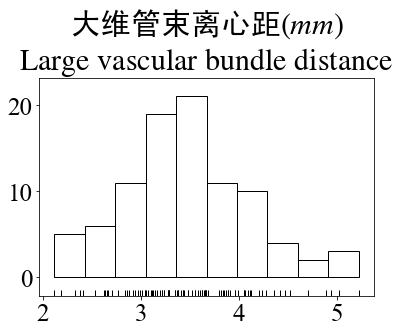

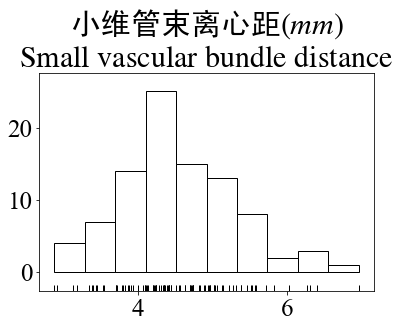

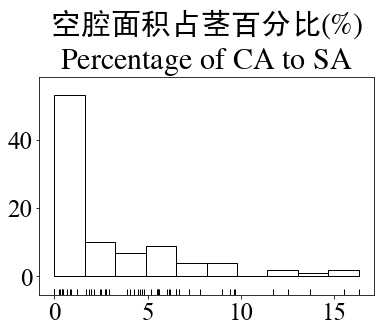

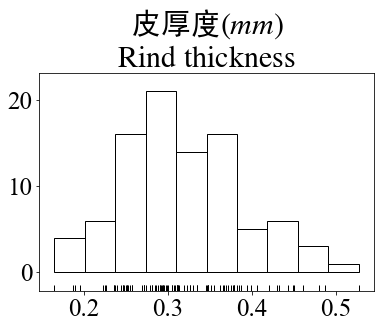

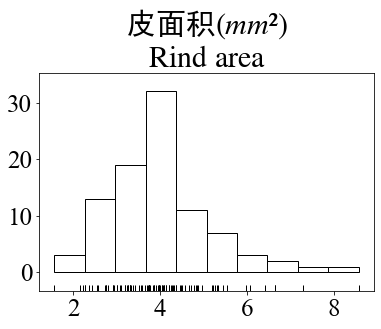

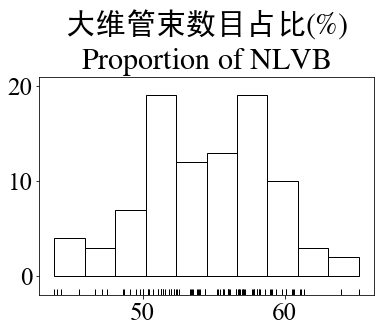

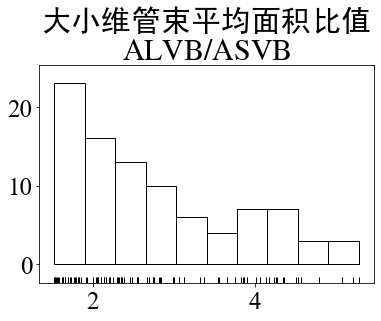

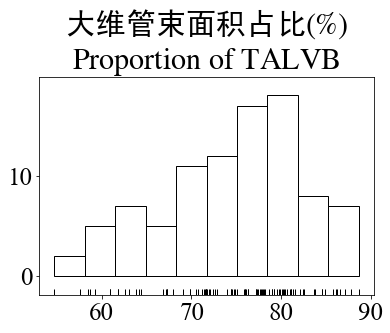

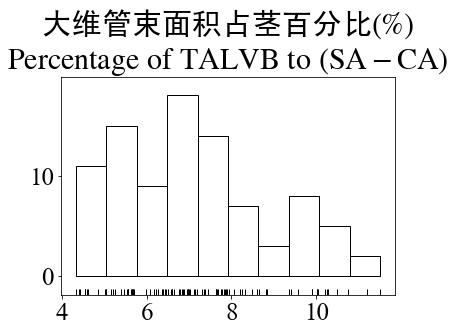

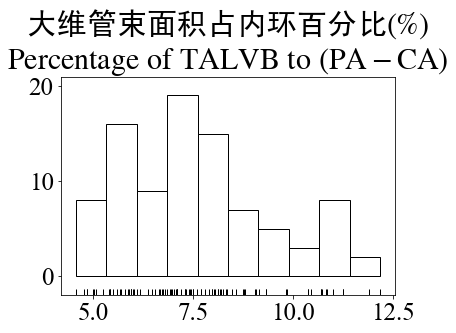

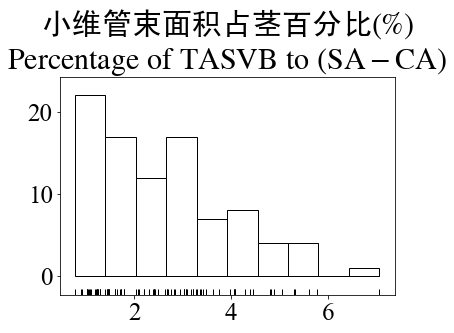

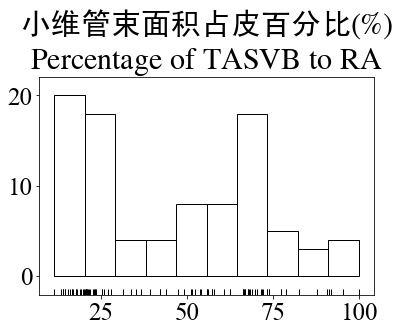

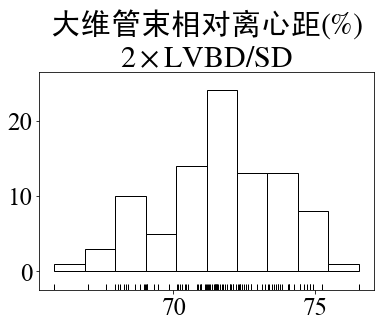

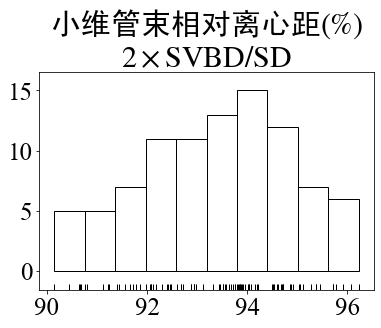

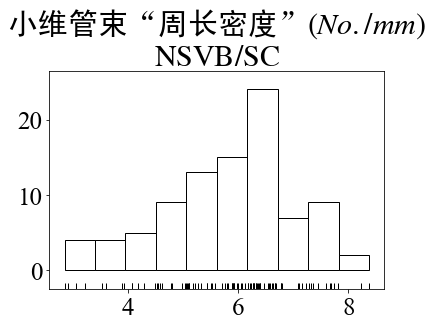

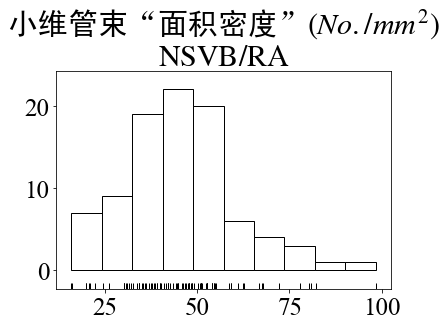

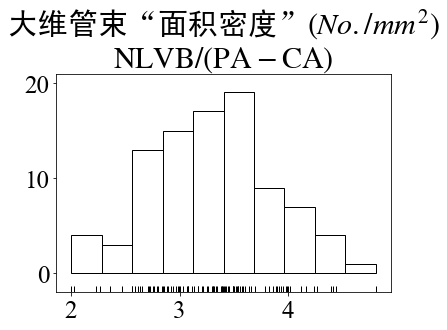

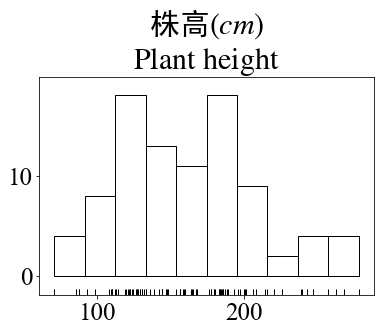

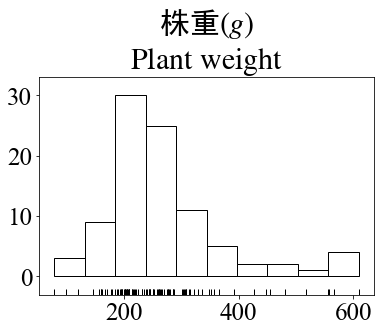

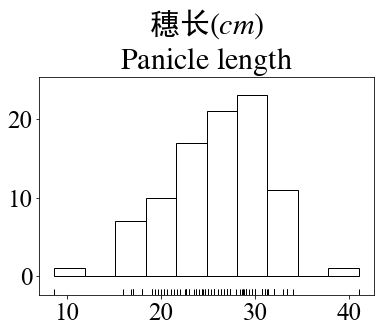

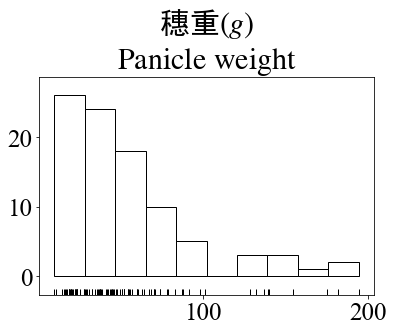

KeyError: '一次枝梗数(No.)'

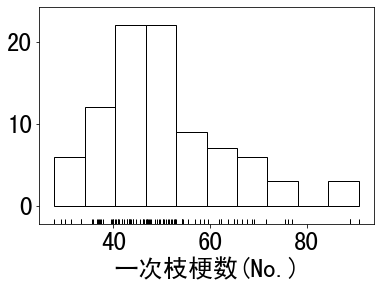

In [66]:
filepath = wd + "陆分析结果/histgram/"
save_histgram(df,eng,filepath)

In [ ]:
# task 3 ： 查看缺失

In [115]:
df.index = data["样本编号"]
df.head(2)

,空腔面积(mm²),茎直径(mm),茎周长(mm),去腔茎面积(mm²),大维管束数目(No.),小维管束数目(No.),总维管束数目(No.),大维管束平均面积(mm²),小维管束平均面积(mm²),大维管束离心距(mm),...,小维管束相对离心距(%),小维管束“周长密度”(No./mm),小维管束“面积密度”(No./mm²),大维管束“面积密度”(No./mm²),株高(cm),株重(g),穗长(cm),穗重(g),一次枝梗数(No.),百粒重(g)
样本编号,,,,,,,,,,,,,,,,,,,,,
NN2/L45,0.0,8.739130,26.968989,56.982278,182,201,383,0.031374,0.019992,3.070015,...,93.790503,7.453004,47.658484,3.449271,121.333333,206.2,24.333333,20.0,41.2,2.3213
NN2/L25,0.0,7.217391,22.207757,38.522474,134,172,306,0.020019,0.012907,2.374729,...,92.938364,7.745042,54.009934,3.791965,129.000000,157.0,41.000000,51.4,42.2,1.9418


In [87]:
def row_col_missing(df):
    rn = pd.DataFrame(df.isnull().sum(axis=1).sort_values(ascending=False))
    rn.columns = ["缺失数"]
    
    cn = pd.DataFrame(df.isnull().sum().sort_values(ascending=False))
    cn.columns = ["缺失数"]
    return rn,cn

In [88]:
rn,cn = row_col_missing(df)

In [85]:
rn.head(2)

,缺失数
样本编号,
NN2/L40,2
NN2/L6,1


In [86]:
cn.head(2)

,缺失数
百粒重(g),9
一次枝梗数(No.),2


In [ ]:
savepath = "../高粱数据20220718.xlsx"
sheet_name = "4.4行缺失情况"
write2excel(rn,savepath,sheet_name)

In [ ]:
savepath = "../高粱数据20220718.xlsx"
sheet_name = "4.4列缺失情况"
write2excel(cn,savepath,sheet_name)

In [ ]:
# task 4 ： 描述性统计

In [91]:
des1 = df_describe(df)

In [92]:
des1.head(2)

,样本数,均值,标准差,最小值,中位数,最大值,变异系数 CV（%）,偏度,峰度
空腔面积(mm²),92.0,1.793813,2.748735,0.000000,0.214228,11.858801,153.234254,2.009975,4.247685
茎直径(mm),92.0,9.714329,1.632149,6.315789,9.594203,14.623188,16.801454,0.415321,0.421659


In [ ]:
savepath = "../高粱数据20220718.xlsx"
sheet_name = "4.4描述性统计"
write2excel(des1,savepath,sheet_name)

In [ ]:
# task 5 ： 直接去掉缺失数据的相关性分析

In [97]:
df.shape

(92, 32)

In [116]:
df_dropna = df.dropna()
df_dropna.shape

(80, 32)

In [ ]:
# 保存数据
savepath = "../高粱数据20220718.xlsx"
sheet_name = "4.4.1"
write2excel(df_dropna,savepath,sheet_name)

In [123]:
df_dropna.head(2)

,空腔面积(mm²),茎直径(mm),茎周长(mm),去腔茎面积(mm²),大维管束数目(No.),小维管束数目(No.),总维管束数目(No.),大维管束平均面积(mm²),小维管束平均面积(mm²),大维管束离心距(mm),...,小维管束相对离心距(%),小维管束“周长密度”(No./mm),小维管束“面积密度”(No./mm²),大维管束“面积密度”(No./mm²),株高(cm),株重(g),穗长(cm),穗重(g),一次枝梗数(No.),百粒重(g)
样本编号,,,,,,,,,,,,,,,,,,,,,
NN2/L45,0.0,8.739130,26.968989,56.982278,182,201,383,0.031374,0.019992,3.070015,...,93.790503,7.453004,47.658484,3.449271,121.333333,206.2,24.333333,20.0,41.2,2.3213
NN2/L25,0.0,7.217391,22.207757,38.522474,134,172,306,0.020019,0.012907,2.374729,...,92.938364,7.745042,54.009934,3.791965,129.000000,157.0,41.000000,51.4,42.2,1.9418


In [126]:
# 标准化
df_dropna_scale = data_standard(df_dropna)
df_dropna_scale.head(2)

,空腔面积(mm²),茎直径(mm),茎周长(mm),去腔茎面积(mm²),大维管束数目(No.),小维管束数目(No.),总维管束数目(No.),大维管束平均面积(mm²),小维管束平均面积(mm²),大维管束离心距(mm),...,小维管束相对离心距(%),小维管束“周长密度”(No./mm),小维管束“面积密度”(No./mm²),大维管束“面积密度”(No./mm²),株高(cm),株重(g),穗长(cm),穗重(g),一次枝梗数(No.),百粒重(g)
样本编号,,,,,,,,,,,,,,,,,,,,,
NN2/L45,-0.662112,-0.563687,-0.462491,-0.438971,-0.347201,0.647252,0.082813,1.487404,2.394663,-0.618015,...,0.348359,1.320628,0.106164,0.185213,-0.873375,-0.572807,-0.353630,-0.911904,-0.684486,0.622447
NN2/L25,-0.662112,-1.651638,-1.568018,-1.368374,-1.109929,0.033593,-0.646982,-0.568916,0.719681,-1.880053,...,-0.236447,1.559696,0.530682,0.809585,-0.701122,-1.045792,2.867776,-0.146256,-0.608681,-0.192444


In [127]:
#皮尔森相关系数
pearson = df_dropna_scale.corr(method="pearson")

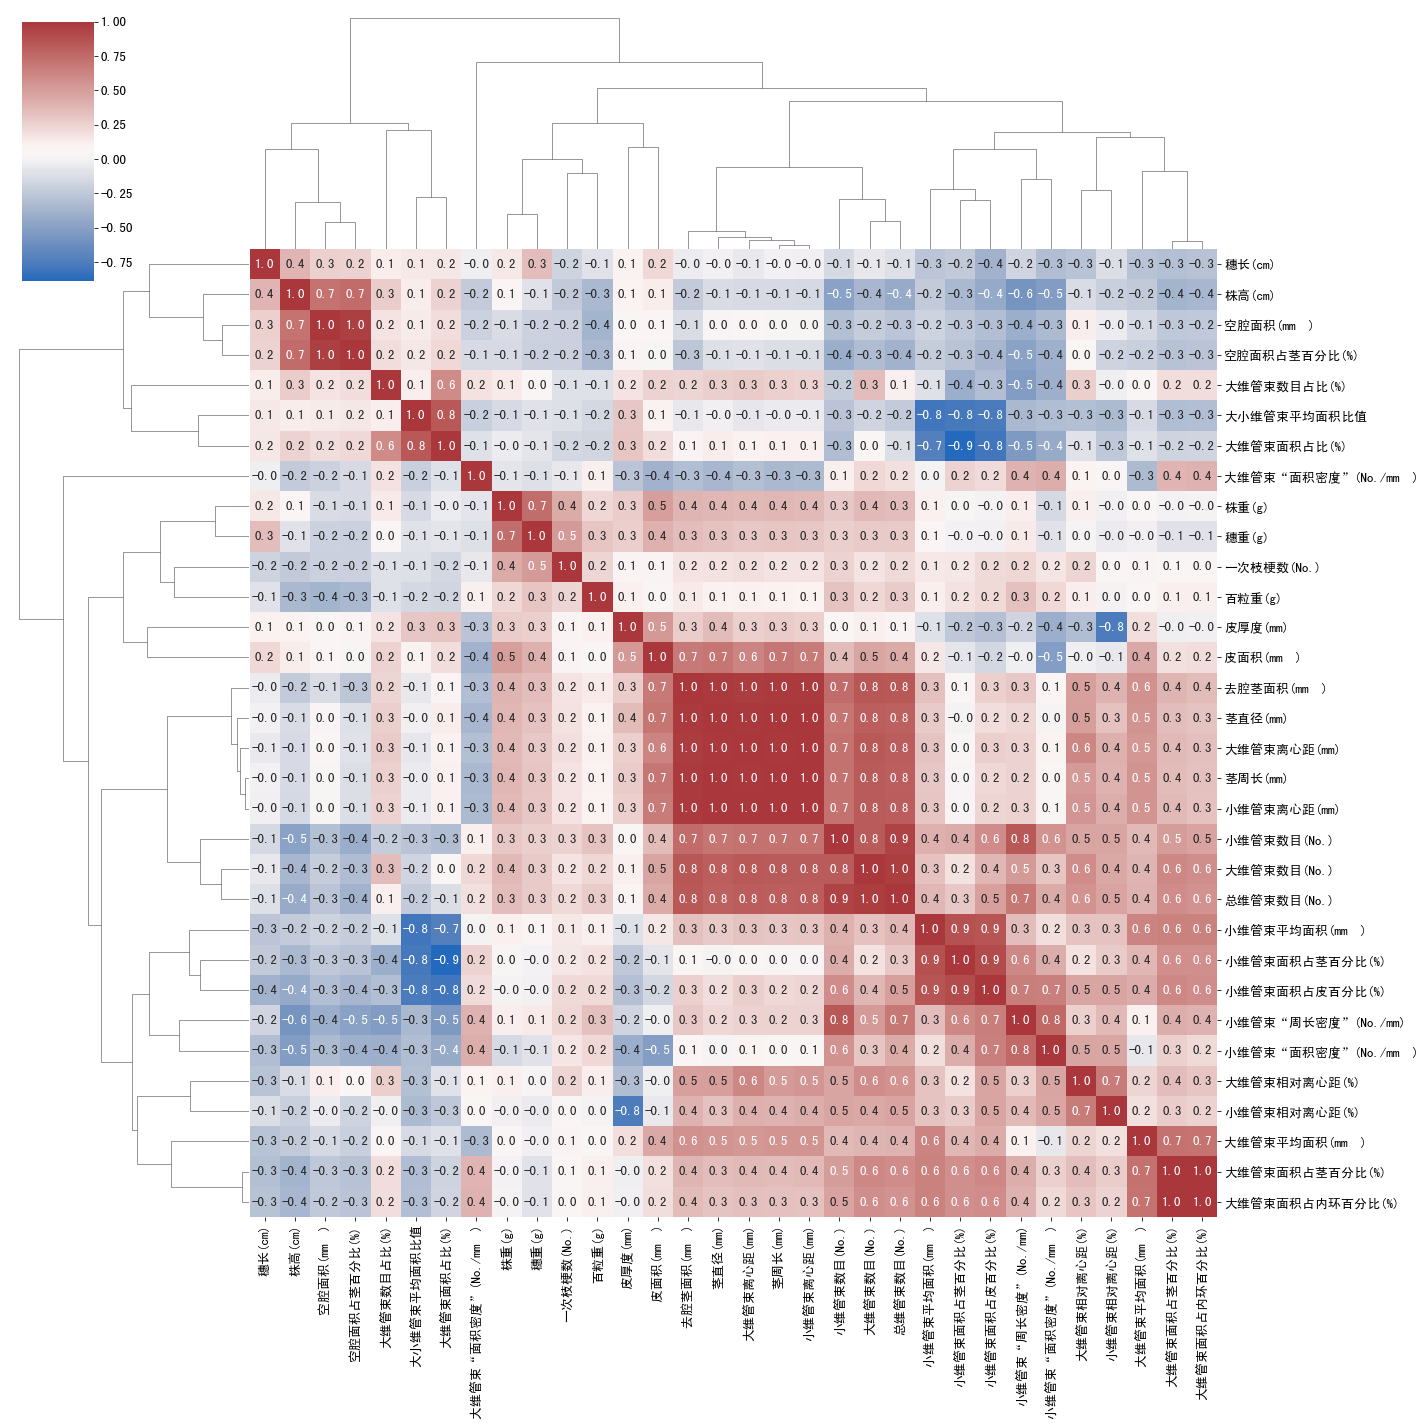

In [162]:
sns.clustermap(pearson,
               cmap="vlag",
#                linewidths=.1,
               figsize=(20, 20),               
               annot=True, 
               fmt="1.1f",                 
               cbar_kws={"shrink": 0.25,"pad":0.01,}
              )

/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


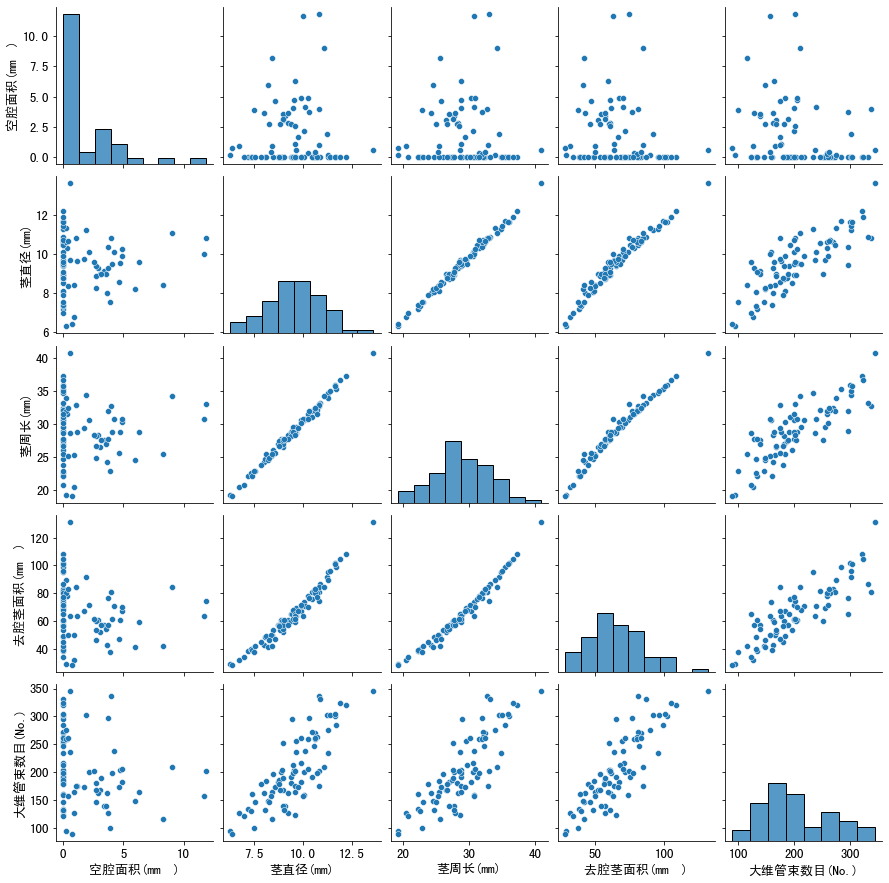

In [164]:
sns.pairplot(df_dropna.iloc[:,:5])
# sns.pairplot(df, vars=[columns_names]) # 选择你想要的变量

In [ ]:
# task 6 ： 填充缺失

In [93]:
k_errors = optimize_k(data=df, target="大维管束数目(No.)",number=20)

In [102]:
k_errors

[{'K': 1, 'RMSE': 14.1166063090323},
 {'K': 2, 'RMSE': 15.385980289656041},
 {'K': 3, 'RMSE': 13.56549725551827},
 {'K': 4, 'RMSE': 14.877172021873683},
 {'K': 5, 'RMSE': 15.258578777716798},
 {'K': 6, 'RMSE': 15.15340555782759},
 {'K': 7, 'RMSE': 15.100586604151303},
 {'K': 8, 'RMSE': 14.271926989723568},
 {'K': 9, 'RMSE': 14.65505624977982},
 {'K': 10, 'RMSE': 14.801948662609473},
 {'K': 11, 'RMSE': 14.987389611550801},
 {'K': 12, 'RMSE': 14.779277099335658},
 {'K': 13, 'RMSE': 13.684085647203467},
 {'K': 14, 'RMSE': 15.008399052039595},
 {'K': 15, 'RMSE': 14.698507084949672},
 {'K': 16, 'RMSE': 15.136647581284302},
 {'K': 17, 'RMSE': 15.201377880760816},
 {'K': 18, 'RMSE': 14.817213140910061},
 {'K': 19, 'RMSE': 14.69924738495854}]

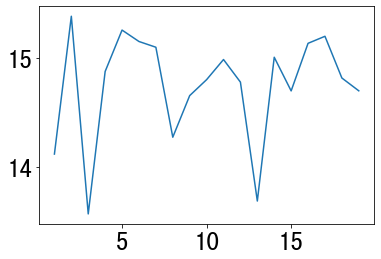

In [95]:
pf = pd.DataFrame(k_errors)
import matplotlib.pyplot as plt
plt.plot(pf["K"],pf["RMSE"])

In [96]:
# 填充缺失
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(imputed, columns=df.columns,index=df.index)

In [165]:
df_imputed.head(2)

,空腔面积(mm²),茎直径(mm),茎周长(mm),去腔茎面积(mm²),大维管束数目(No.),小维管束数目(No.),总维管束数目(No.),大维管束平均面积(mm²),小维管束平均面积(mm²),大维管束离心距(mm),...,小维管束相对离心距(%),小维管束“周长密度”(No./mm),小维管束“面积密度”(No./mm²),大维管束“面积密度”(No./mm²),株高(cm),株重(g),穗长(cm),穗重(g),一次枝梗数(No.),百粒重(g)
样本编号,,,,,,,,,,,,,,,,,,,,,
NN2/L45,0.0,8.739130,26.968989,56.982278,182.0,201.0,383.0,0.031374,0.019992,3.070015,...,93.790503,7.453004,47.658484,3.449271,121.333333,206.2,24.333333,20.0,41.2,2.3213
NN2/L25,0.0,7.217391,22.207757,38.522474,134.0,172.0,306.0,0.020019,0.012907,2.374729,...,92.938364,7.745042,54.009934,3.791965,129.000000,157.0,41.000000,51.4,42.2,1.9418


In [166]:
df_imputed.shape

(92, 32)

In [ ]:
# 保存数据
savepath = "../高粱数据20220718.xlsx"
sheet_name = "4.4缺失填充"
write2excel(df_imputed,savepath,sheet_name)

In [ ]:
# task 7 ： 填充缺失后的描述性统计、相关性分析

In [167]:
des2 = df_describe(df_imputed)

In [168]:
des2.head(2)

,样本数,均值,标准差,最小值,中位数,最大值,变异系数 CV（%）,偏度,峰度
空腔面积(mm²),92.0,1.793813,2.748735,0.000000,0.214228,11.858801,153.234254,2.009975,4.247685
茎直径(mm),92.0,9.714329,1.632149,6.315789,9.594203,14.623188,16.801454,0.415321,0.421659


In [ ]:
savepath = "../高粱数据20220718.xlsx"
sheet_name = "4.5描述性统计"
write2excel(des2,savepath,sheet_name)

In [169]:
# 标准化
df_imputed_scale = data_standard(df_imputed)
df_imputed_scale.head(2)

,空腔面积(mm²),茎直径(mm),茎周长(mm),去腔茎面积(mm²),大维管束数目(No.),小维管束数目(No.),总维管束数目(No.),大维管束平均面积(mm²),小维管束平均面积(mm²),大维管束离心距(mm),...,小维管束相对离心距(%),小维管束“周长密度”(No./mm),小维管束“面积密度”(No./mm²),大维管束“面积密度”(No./mm²),株高(cm),株重(g),穗长(cm),穗重(g),一次枝梗数(No.),百粒重(g)
样本编号,,,,,,,,,,,,,,,,,,,,,
NN2/L45,-0.656171,-0.600768,-0.514463,-0.487288,-0.404311,0.549925,0.001052,1.246367,2.299554,-0.653950,...,0.287656,1.345286,0.128387,0.254993,-0.898088,-0.586600,-0.306855,-0.876443,-0.685950,0.644751
NN2/L25,-0.656171,-1.538230,-1.463484,-1.242498,-1.112818,-0.029767,-0.676374,-0.541691,0.699316,-1.745169,...,-0.292013,1.586237,0.548966,0.862242,-0.726558,-1.071505,2.940539,-0.081670,-0.609298,-0.199641


In [170]:
#皮尔森相关系数
pearson = df_imputed_scale.corr(method="pearson")

/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  fig.canvas.draw()
/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:660: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  bboxes = [l.get_window_extent() for l in labels]
/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:1203: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  self._figure.tight_layout(**tight_params)


/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


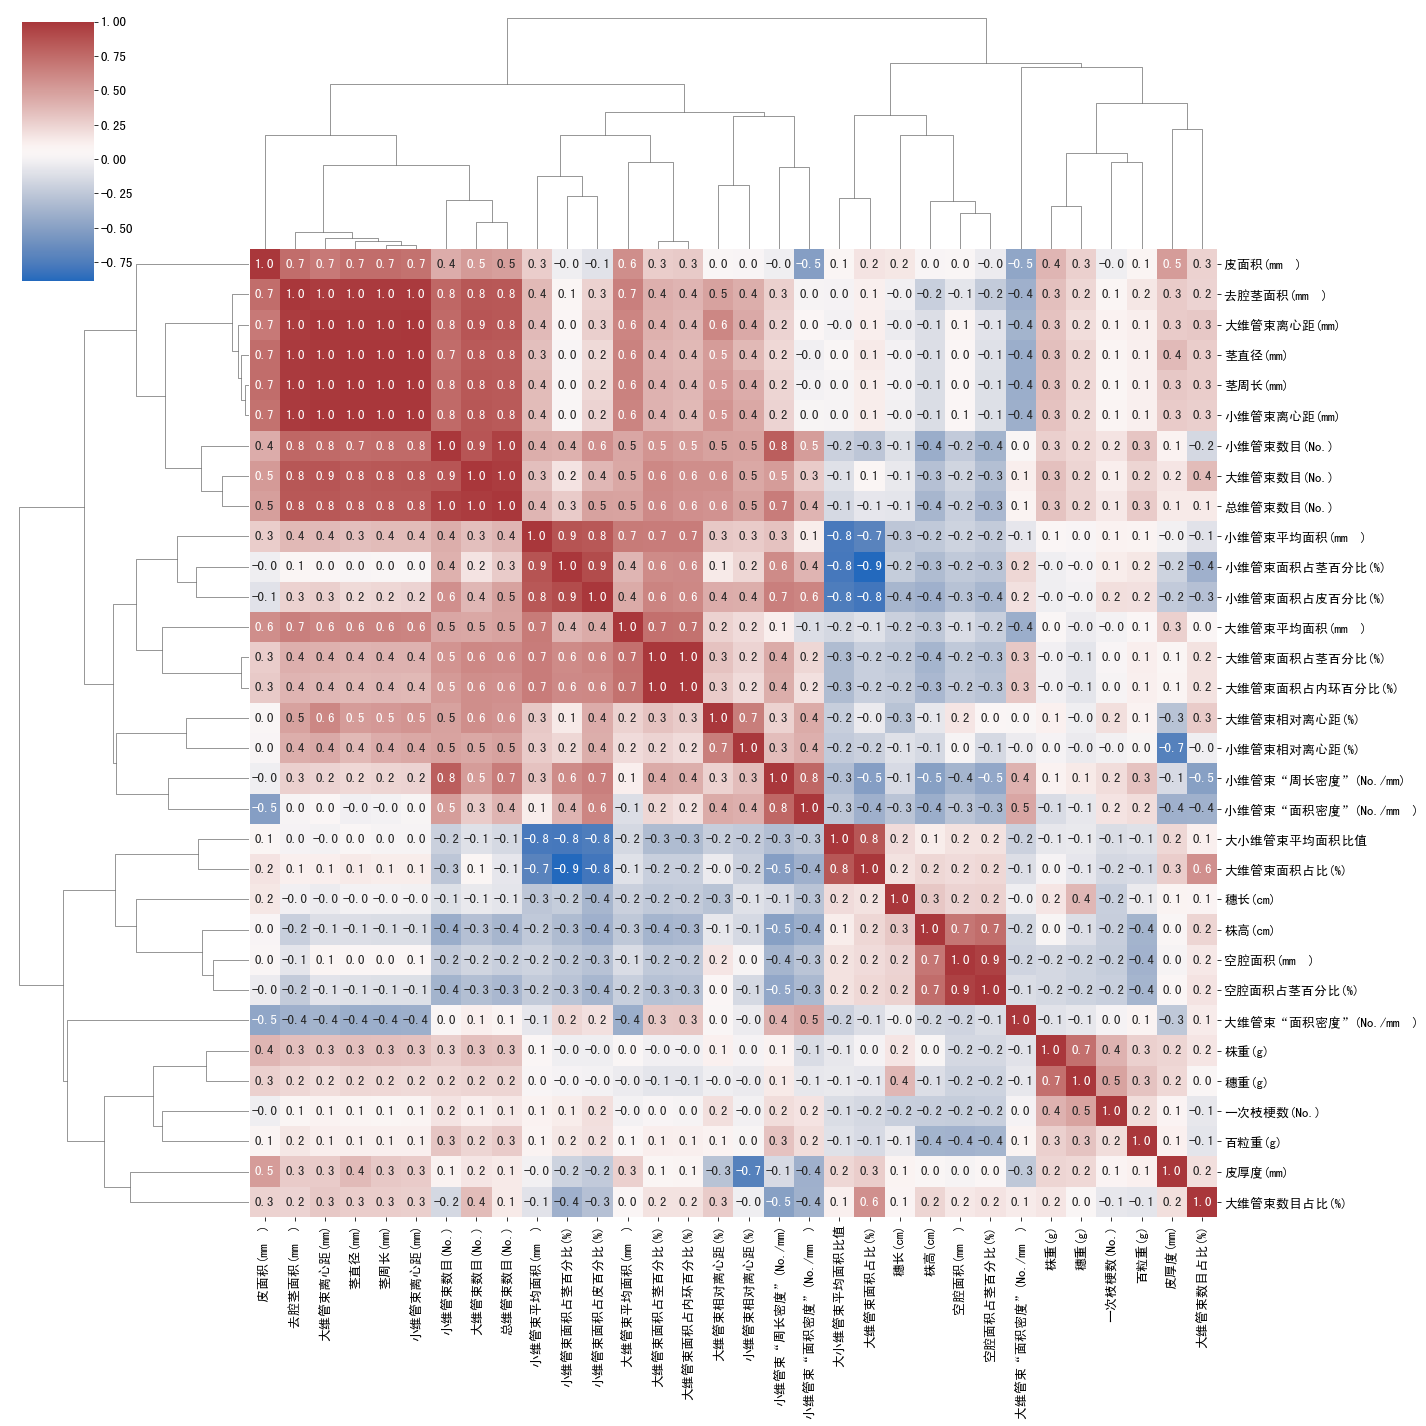

In [171]:
sns.clustermap(pearson,
               cmap="vlag",
#                linewidths=.1,
               figsize=(20, 20),               
               annot=True, 
               fmt="1.1f",                 
               cbar_kws={"shrink": 0.25,"pad":0.01,}
              )

In [ ]:
# task 8 ： 聚类分析

In [180]:
def plot_dend(data_scaled,savepath):
    """
    绘制层次聚类图
    data：index 是经过正则化或标准化的数据
    savepath：图片保存的路径
    """
    import scipy.cluster.hierarchy as shc
    plt.figure(figsize=(20, 7))  
#     plt.title("Dendrograms")  
    Z = shc.linkage(data_scaled,method='ward',metric='euclidean') 
    dend = shc.dendrogram(Z,labels=data_scaled.index)

    plt.xticks(fontsize=15)
#     plt.xticks(rotation=60)
    # plt.axhline(y=5.5, color='r', linestyle='--') # 画一条横线
    plt.savefig(savepath,bbox_inches = 'tight')

In [173]:
df_imputed.head(2)

,空腔面积(mm²),茎直径(mm),茎周长(mm),去腔茎面积(mm²),大维管束数目(No.),小维管束数目(No.),总维管束数目(No.),大维管束平均面积(mm²),小维管束平均面积(mm²),大维管束离心距(mm),...,小维管束相对离心距(%),小维管束“周长密度”(No./mm),小维管束“面积密度”(No./mm²),大维管束“面积密度”(No./mm²),株高(cm),株重(g),穗长(cm),穗重(g),一次枝梗数(No.),百粒重(g)
样本编号,,,,,,,,,,,,,,,,,,,,,
NN2/L45,0.0,8.739130,26.968989,56.982278,182.0,201.0,383.0,0.031374,0.019992,3.070015,...,93.790503,7.453004,47.658484,3.449271,121.333333,206.2,24.333333,20.0,41.2,2.3213
NN2/L25,0.0,7.217391,22.207757,38.522474,134.0,172.0,306.0,0.020019,0.012907,2.374729,...,92.938364,7.745042,54.009934,3.791965,129.000000,157.0,41.000000,51.4,42.2,1.9418


In [177]:
df_imputed_normalized = data_normalize(df_imputed) # 正则化

In [179]:
df_imputed_normalized.head(2)

,空腔面积(mm²),茎直径(mm),茎周长(mm),去腔茎面积(mm²),大维管束数目(No.),小维管束数目(No.),总维管束数目(No.),大维管束平均面积(mm²),小维管束平均面积(mm²),大维管束离心距(mm),...,小维管束相对离心距(%),小维管束“周长密度”(No./mm),小维管束“面积密度”(No./mm²),大维管束“面积密度”(No./mm²),株高(cm),株重(g),穗长(cm),穗重(g),一次枝梗数(No.),百粒重(g)
样本编号,,,,,,,,,,,,,,,,,,,,,
NN2/L45,0.0,0.015562,0.048024,0.101469,0.324089,0.357922,0.682010,0.000056,0.000036,0.005467,...,0.167013,0.013272,0.084866,0.006142,0.216059,0.367182,0.043331,0.035614,0.073365,0.004134
NN2/L25,0.0,0.015511,0.047728,0.082791,0.287987,0.369655,0.657643,0.000043,0.000028,0.005104,...,0.199739,0.016645,0.116076,0.008150,0.277241,0.337418,0.088116,0.110467,0.090695,0.004173


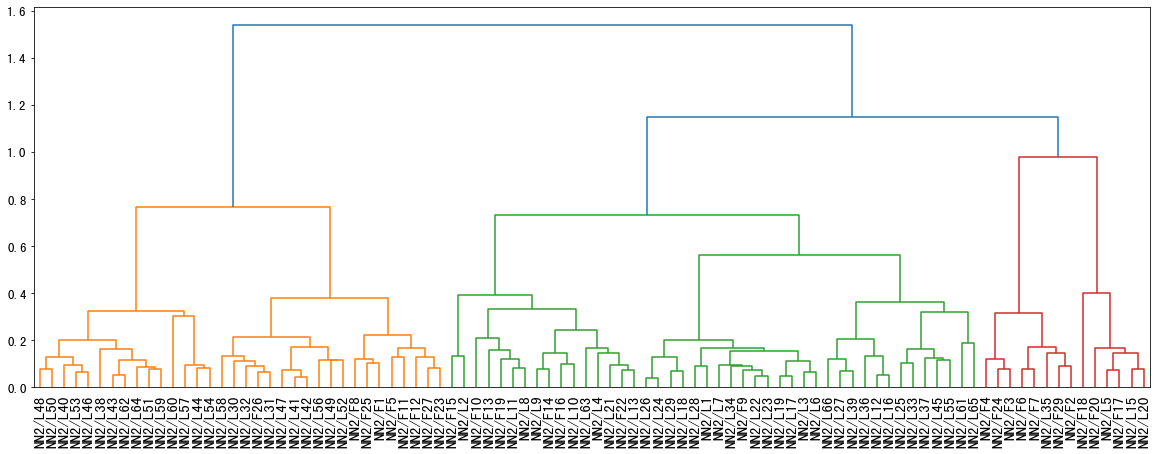

In [181]:
savepath = wd + "陆分析结果/聚类图.pdf"
plot_dend(df_imputed_normalized,savepath)

In [187]:
def make_cluster(data,n_clusters,method):
    """
    聚类并将类别添加到 data 中为新一列
    data：index 是 sample name，列是变量/性状的 DataFrame
    n_clusters：想要聚成几类，数字
    """
    if method == "normalize":
        data_scaled = data_normalize(data)
    elif method == " standardize":
        data_scaled = data_standard(data)
        
    from sklearn.cluster import AgglomerativeClustering
    cluster = AgglomerativeClustering(n_clusters=n_clusters,linkage='ward',affinity='euclidean')  
    cluster_res = cluster.fit_predict(data_scaled)
    
    data["cluster"] = cluster_res
    data["cluster"] = data["cluster"] + 1
    
    return data

In [210]:
df_cluster = make_cluster(df_imputed,3,"normalize")
df_cluster.head(2)

,空腔面积(mm²),茎直径(mm),茎周长(mm),去腔茎面积(mm²),大维管束数目(No.),小维管束数目(No.),总维管束数目(No.),大维管束平均面积(mm²),小维管束平均面积(mm²),大维管束离心距(mm),...,小维管束“周长密度”(No./mm),小维管束“面积密度”(No./mm²),大维管束“面积密度”(No./mm²),株高(cm),株重(g),穗长(cm),穗重(g),一次枝梗数(No.),百粒重(g),cluster
样本编号,,,,,,,,,,,,,,,,,,,,,
NN2/L45,0.0,8.739130,26.968989,56.982278,182.0,201.0,383.0,0.031374,0.019992,3.070015,...,7.453004,47.658484,3.449271,121.333333,206.2,24.333333,20.0,41.2,2.3213,3
NN2/L25,0.0,7.217391,22.207757,38.522474,134.0,172.0,306.0,0.020019,0.012907,2.374729,...,7.745042,54.009934,3.791965,129.000000,157.0,41.000000,51.4,42.2,1.9418,3


In [211]:
df_cluster.head(2)

,空腔面积(mm²),茎直径(mm),茎周长(mm),去腔茎面积(mm²),大维管束数目(No.),小维管束数目(No.),总维管束数目(No.),大维管束平均面积(mm²),小维管束平均面积(mm²),大维管束离心距(mm),...,小维管束“周长密度”(No./mm),小维管束“面积密度”(No./mm²),大维管束“面积密度”(No./mm²),株高(cm),株重(g),穗长(cm),穗重(g),一次枝梗数(No.),百粒重(g),cluster
样本编号,,,,,,,,,,,,,,,,,,,,,
NN2/L45,0.0,8.739130,26.968989,56.982278,182.0,201.0,383.0,0.031374,0.019992,3.070015,...,7.453004,47.658484,3.449271,121.333333,206.2,24.333333,20.0,41.2,2.3213,3
NN2/L25,0.0,7.217391,22.207757,38.522474,134.0,172.0,306.0,0.020019,0.012907,2.374729,...,7.745042,54.009934,3.791965,129.000000,157.0,41.000000,51.4,42.2,1.9418,3


In [ ]:
# 保存数据
savepath = "../高粱数据20220718.xlsx"
sheet_name = "4.5聚类结果"
write2excel(df_cluster,savepath,sheet_name)

In [212]:
cols_org = df_cluster.columns.tolist()

In [213]:
cols = [cols_org[-1]] + cols_org[:-1]

In [215]:
cols[:5]

['cluster', '空腔面积(mm²)', '茎直径(mm)', '茎周长(mm)', '去腔茎面积(mm²)']

In [216]:
df_cluster = df_cluster[cols]

In [217]:
df_cluster.head(2)

,cluster,空腔面积(mm²),茎直径(mm),茎周长(mm),去腔茎面积(mm²),大维管束数目(No.),小维管束数目(No.),总维管束数目(No.),大维管束平均面积(mm²),小维管束平均面积(mm²),...,小维管束相对离心距(%),小维管束“周长密度”(No./mm),小维管束“面积密度”(No./mm²),大维管束“面积密度”(No./mm²),株高(cm),株重(g),穗长(cm),穗重(g),一次枝梗数(No.),百粒重(g)
样本编号,,,,,,,,,,,,,,,,,,,,,
NN2/L45,3,0.0,8.739130,26.968989,56.982278,182.0,201.0,383.0,0.031374,0.019992,...,93.790503,7.453004,47.658484,3.449271,121.333333,206.2,24.333333,20.0,41.2,2.3213
NN2/L25,3,0.0,7.217391,22.207757,38.522474,134.0,172.0,306.0,0.020019,0.012907,...,92.938364,7.745042,54.009934,3.791965,129.000000,157.0,41.000000,51.4,42.2,1.9418


In [221]:
def vb_cluster_box_main_plot(x,y,trait,names):
    sns.boxplot(x=x,y=y,palette=color,boxprops=dict(alpha=.4),showfliers=False) # 画图
    sns.swarmplot(x=x,y=y,palette=color)

    ylabel = names.loc[trait,"性状无单位"] + names.loc[trait,"单位数学格式"] + "\n" + names.loc[trait,"英文全称数学格式"]
    plt.ylabel(ylabel) # ylable 文字
    plt.xlabel(None)  # 去掉 xlable

/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 44.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 47.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


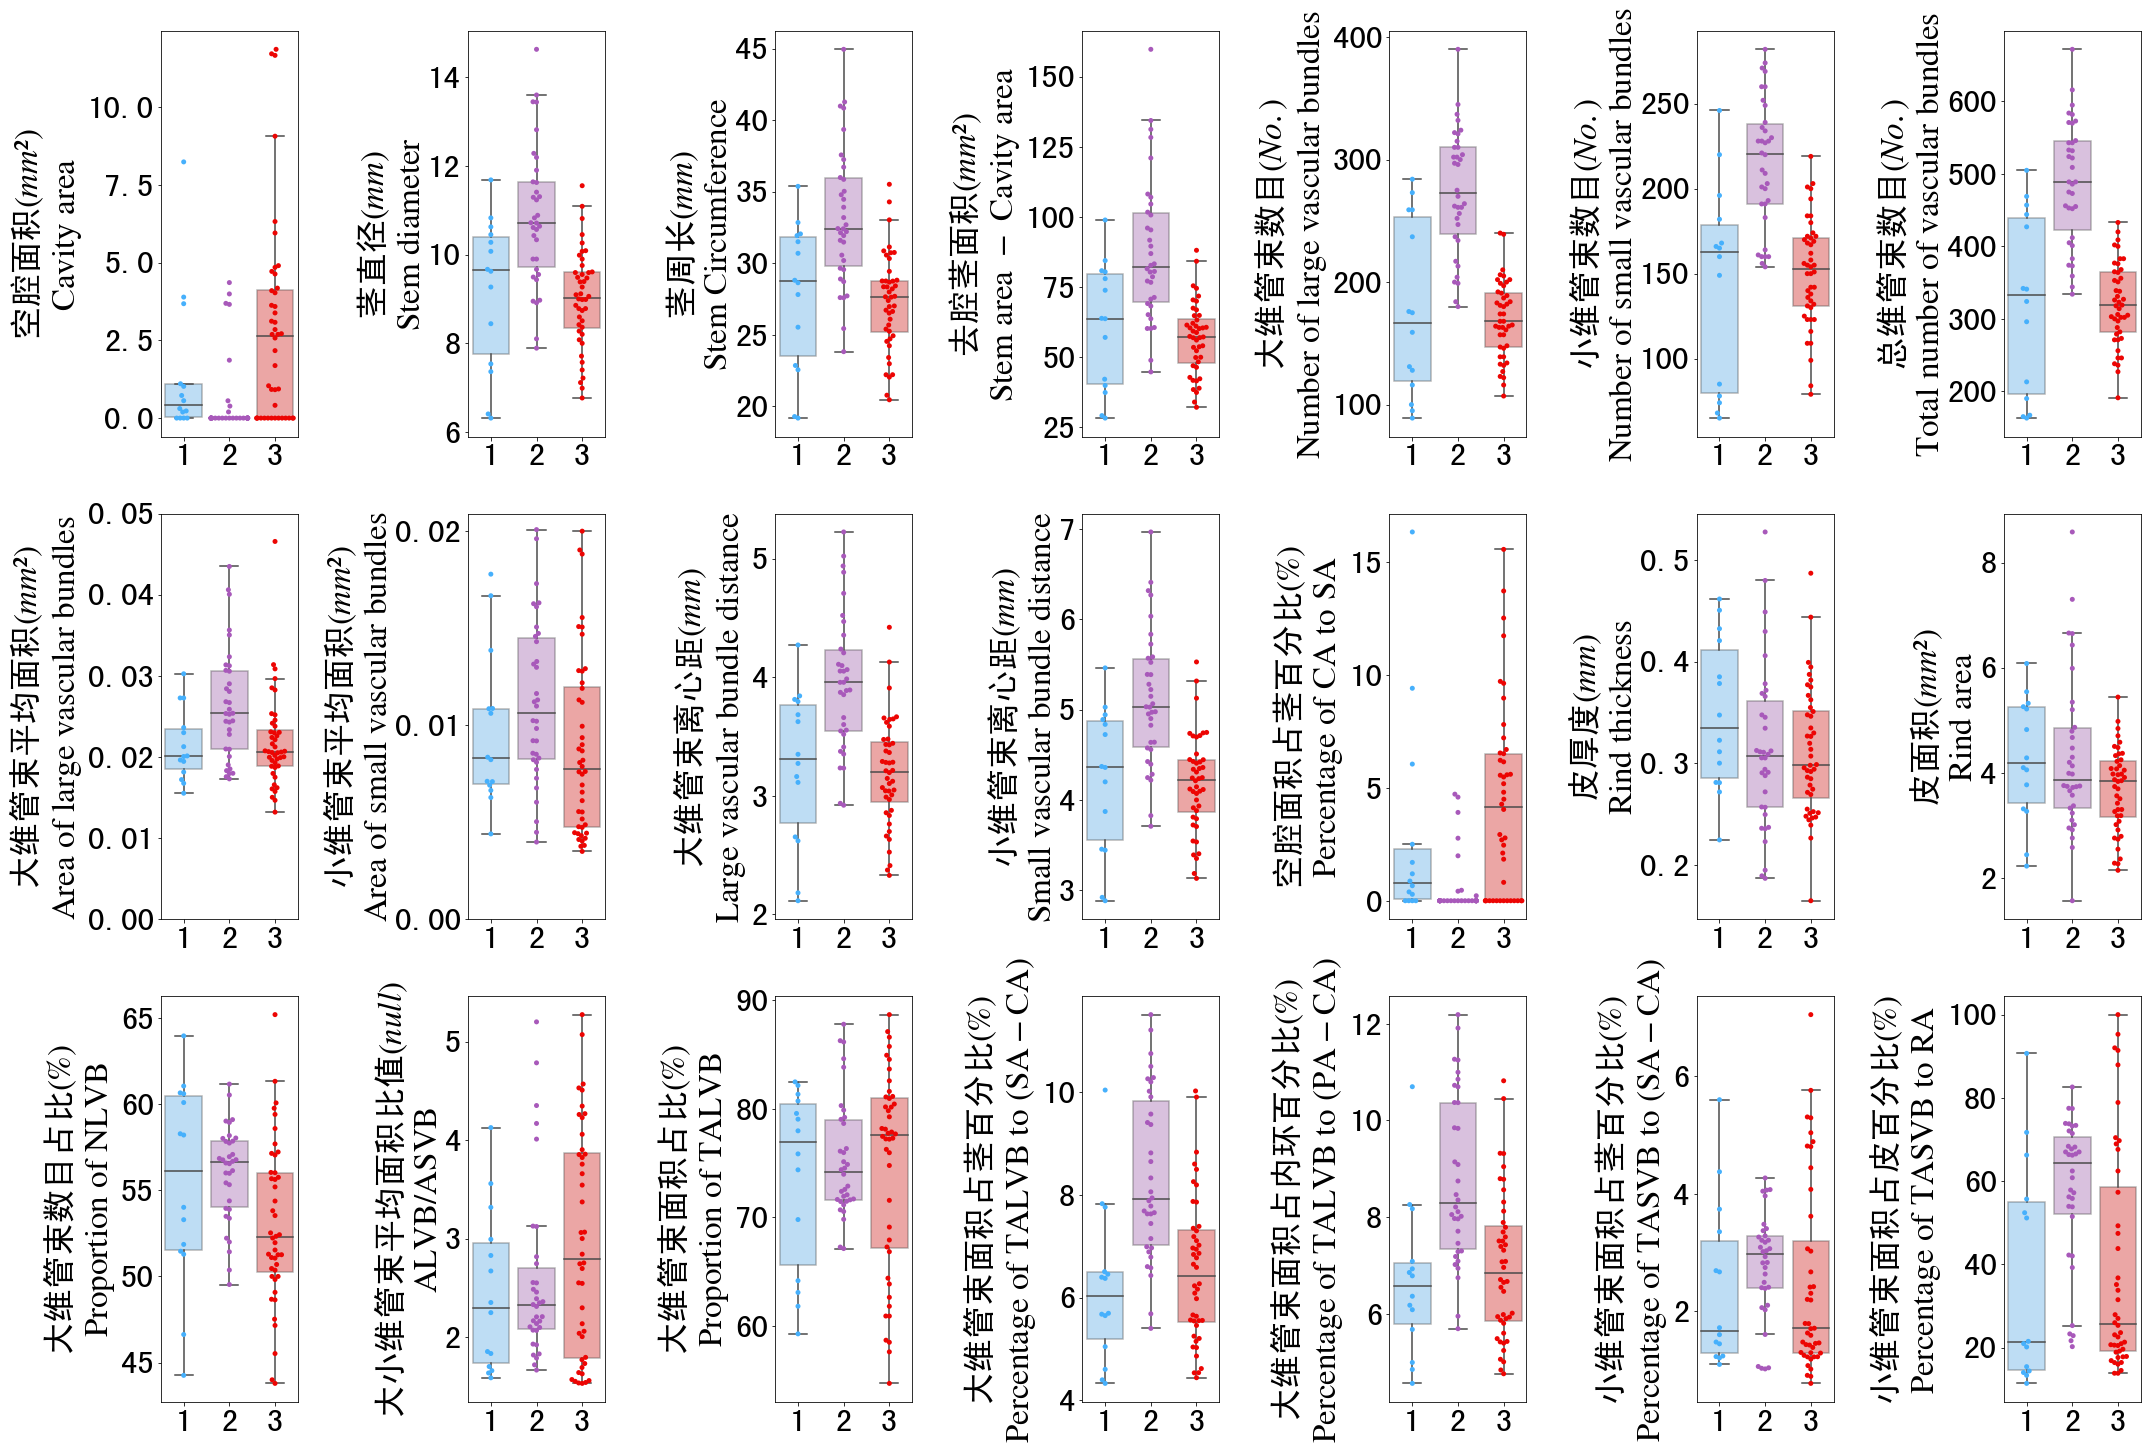

In [224]:
from matplotlib import gridspec
fig = plt.figure(figsize=(30, 20))
gs = gridspec.GridSpec(3,7)  #     gs = gridspec.GridSpec(2,3, width_ratios=[2,2,3.5]) 
color = ["#46b0fc","#a859ba", "#ec0503", "#00d6ac" ]

for i in range(21):
    ax = plt.subplot(gs[i])          
        
    trait = cols[i+1]
    x = df_cluster["cluster"]
    y = df_cluster[trait]
    vb_cluster_box_main_plot(x,y,trait,eng) # 画核心部分图
    
    if trait == "大维管束平均面积(mm²)" :
        plt.yticks(np.arange(0, 0.051, step=0.01)) # 刻度太密集，手工设置刻度
    elif trait == "小维管束平均面积(mm²)":
        plt.yticks(np.arange(0, 0.021, step=0.01)) # 刻度太密集，手工设置刻度

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
savepath = wd + "陆分析结果/箱线图3乘7v5.pdf"
plt.savefig(savepath, bbox_inches = 'tight')
plt.show() 

In [236]:
# 性状的顺序，以及对应的格式
zwdw = eng.index.tolist()
zw = eng["性状无单位"].tolist()
yw = eng["英文全称数学格式"].tolist()

In [226]:
# 中英文名称
zyw = []
for i in range(len(zw)):
    x = zw[i] + "\n" + yw[i]
    zyw.append(x)

In [227]:
df_cluster.head(2)

,cluster,空腔面积(mm²),茎直径(mm),茎周长(mm),去腔茎面积(mm²),大维管束数目(No.),小维管束数目(No.),总维管束数目(No.),大维管束平均面积(mm²),小维管束平均面积(mm²),...,小维管束相对离心距(%),小维管束“周长密度”(No./mm),小维管束“面积密度”(No./mm²),大维管束“面积密度”(No./mm²),株高(cm),株重(g),穗长(cm),穗重(g),一次枝梗数(No.),百粒重(g)
样本编号,,,,,,,,,,,,,,,,,,,,,
NN2/L45,3,0.0,8.739130,26.968989,56.982278,182.0,201.0,383.0,0.031374,0.019992,...,93.790503,7.453004,47.658484,3.449271,121.333333,206.2,24.333333,20.0,41.2,2.3213
NN2/L25,3,0.0,7.217391,22.207757,38.522474,134.0,172.0,306.0,0.020019,0.012907,...,92.938364,7.745042,54.009934,3.791965,129.000000,157.0,41.000000,51.4,42.2,1.9418


In [249]:
def df_cluster_mean(df_cluster,cols_order):
    """
    把数据进行标准化后，按照类别计算均值
    df_cluster：index 是样本，cluster 仍作为列在变量中，其余列为变量
    """   
    df_cluster_scale = df_cluster.set_index("cluster")
    df_cluster_scale = data_standard(df_cluster_scale) # 标准化
    df_cluster_scale = df_cluster_scale.reset_index()
    df_cluster_scale_mean = df_cluster_scale.groupby("cluster").mean() # 求平均
    df_cluster_scale_mean_order = df_cluster_scale_mean[cols_order] # 性状排序
    
    return df_cluster_scale_mean_order

In [250]:
df_cluster_scale_mean_order = df_cluster_mean(df_cluster,zwdw)

In [251]:
df_cluster_scale_mean_order.head()

,株高(cm),株重(g),穗长(cm),穗重(g),一级枝梗数(No.),千粒重(g),大维管束数目(No.),小维管束数目(No.),总维管束数目(No.),大维管束数目占比(%),...,皮厚度(mm),皮面积(mm²),大维管束面积占茎百分比(%),大维管束面积占内环百分比(%),小维管束面积占茎百分比(%),小维管束面积占皮百分比(%),小维管束“周长密度”(No./mm),小维管束“面积密度”(No./mm²),大维管束“面积密度”(No./mm²),空腔面积占茎百分比(%)
cluster,,,,,,,,,,,,,,,,,,,,,
1,0.485338,1.295293,0.291593,1.136885,0.670786,0.298921,-0.474951,-0.580902,-0.538753,0.204500,...,0.418696,0.226196,-0.544689,-0.505661,-0.137936,-0.338722,-0.600282,-0.694002,-0.279723,0.030217
2,-0.645904,-0.001620,-0.331274,-0.120754,0.098415,0.311765,0.956700,0.826836,0.934130,0.340401,...,-0.054544,0.259381,0.682829,0.644080,0.153148,0.476743,0.540098,0.536328,0.206032,-0.550720
3,0.344682,-0.410887,0.163205,-0.268427,-0.289480,-0.336021,-0.588147,-0.454086,-0.550407,-0.328105,...,-0.091074,-0.272402,-0.354330,-0.336806,-0.074453,-0.260617,-0.226349,-0.193616,-0.070203,0.415942


In [272]:
def cluster_plt(data,zyw,savepath,method):
    """
    画聚类类别性状均值的折线图
    data：经过标准化或其他 proprocessing 处理的 DataFrame，使不同量纲的数据处于可比范围
    savepath：图片保存的路径
    """   
    colors = ["#46b0fc","#a859ba", "#ec0503", "#00d6ac" ]
    # 画每一行/类的折线图
    length = data.shape[0]
    plt.figure(figsize=(20, 7))  
    for i in range(length):
        label = "Class" + str(i+1)        
#         plt.plot(data.columns,data.iloc[i],c=colors[i],label=label,marker='o')
        plt.plot(data.columns,data.iloc[i],c=colors[i],label=label,marker='o')

    
    plt.legend() 
    if method == "normalize":
        ylabel = "正则化数值" + "\n" + "$Normalized\ values$"
    elif method == " standardize":
        ylabel = "标准化数值" + "\n" + "$Standardized\ values$"      
    plt.ylabel(ylabel) # ylabel 文字
    
    cols = data.columns.tolist()
    plt.xticks(rotation=80,ticks=cols,labels=zyw) # xticks 格式和文字
#     plt.gca().get_xticklabels().set_horizontalalignment('right') # xticks 右对齐
    for label in plt.gca().get_xticklabels():
        label.set_horizontalalignment('right') 
         
    plt.savefig(savepath, bbox_inches = 'tight')

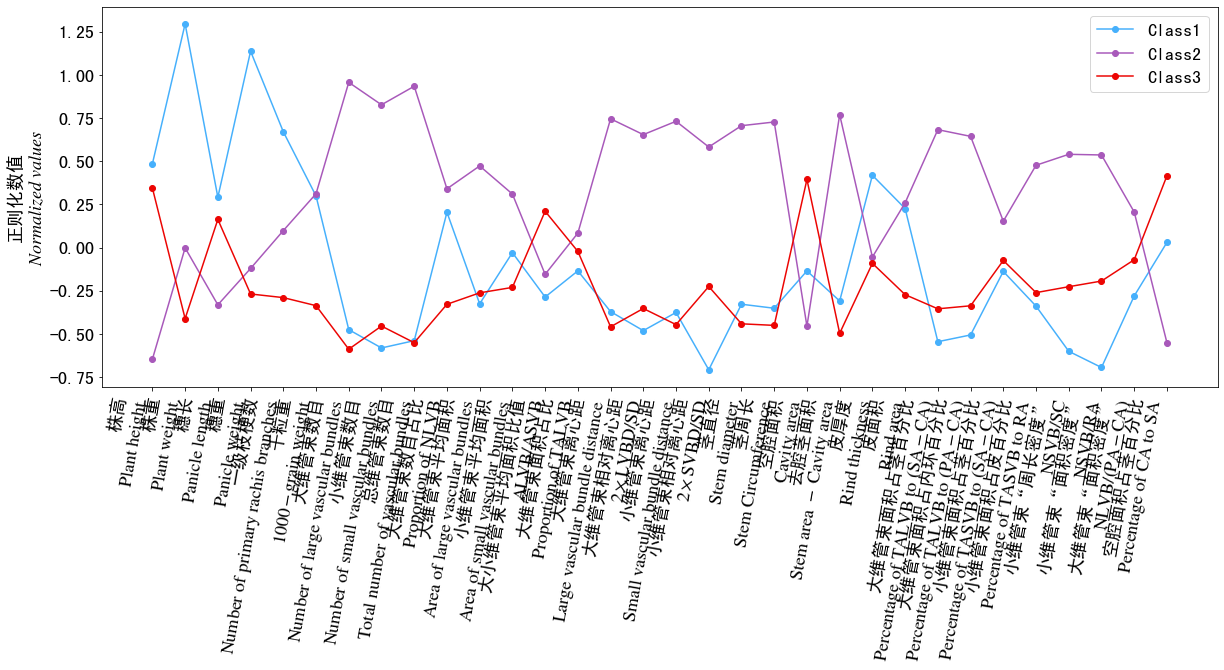

In [273]:
savepath = wd + "陆分析结果/聚类线图.pdf"
method = "normalize"
cluster_plt(df_cluster_scale_mean_order,zyw,savepath,method)

In [ ]:
# 4.6.1 样本编号，样本名称和类别匹配

In [274]:
d461 = pd.read_excel("../高粱数据20220718.xlsx",sheet_name="4.6.1")
c = pd.read_excel("../高粱数据20220718.xlsx",sheet_name="4.6.1聚类结果")

In [275]:
d461.head(2)

,样本编号,品种编号,品种名称,来源,备注,空腔面积(mm²),茎直径(mm),皮厚度(mm),大维管束数目(No.),小维管束数目(No.),...,小维管束面积占皮百分比(%),大维管束相对离心距(%),小维管束“周长密度”(No./mm),大维管束“面积密度”(No./mm²),株高(cm),株重(g),穗长(cm),穗重(g),一级枝梗数(No.),千粒重(g)
0,NN2/L33,L33,糯3,中国北方,NaN,4.846927,9.898551,0.404461,183,219,...,44.122320,74.082496,7.221269,2.837600,144.000000,214.666667,21.333333,79.2,68.6,22.635
1,NN2/L45,L45,GW000385,印度,NaN,0.000000,8.739130,0.548705,182,201,...,36.141898,70.259043,7.453004,3.449271,121.333333,206.200000,24.333333,20.0,41.2,23.213


In [277]:
d461_some = d461.iloc[:,:3]
d461_some.head(2)

,样本编号,品种编号,品种名称
0,NN2/L33,L33,糯3
1,NN2/L45,L45,GW000385


In [278]:
d461_some.shape

(92, 3)

In [276]:
c.head(2)

,品种名称,cluster
0,糯3,1
1,GW000385,1


In [279]:
c.shape

(92, 2)

In [280]:
d461_c = pd.merge(d461_some,c)
d461_c.shape

(92, 4)

In [281]:
d461_c.head()

,样本编号,品种编号,品种名称,cluster
0,NN2/L33,L33,糯3,1
1,NN2/L45,L45,GW000385,1
2,NN2/L55,L55,GW002103,1
3,NN2/L63,L63,GW002139,1
4,NN2/F6,F6,川糯梁1号,3


In [282]:
d461_c["cluster"].value_counts()

1    44
2    38
3    10
Name: cluster, dtype: int64

In [283]:
d461_c.to_excel("../4.6.1聚类结果.xlsx")

In [ ]:
# 散点图拼图

In [ ]:
fig = plt.figure(figsize=(30, 18))
gs = gridspec.GridSpec(3,4)  #     gs = gridspec.GridSpec(2,3, width_ratios=[2,2,3.5]) 


# 先画穗重
for i in range(4):
    ax = plt.subplot(gs[i])
#     ax0 = fig.add_subplot(gs[0, 0])

    y = hxh1[[zs_order[0]]]
    x = hxh1[[sz_order[i]]]

    p = sns.regplot(x,y,data=hxh1,color="b",scatter_kws={'alpha':0.3})

    ylabel = names.loc[zs_order[0],"性状无单位"] + names.loc[zs_order[0],"单位"] + "\n" + names.loc[zs_order[0],"英文公式"]
    xlabel = names.loc[sz_order[i],"性状无单位"] + names.loc[sz_order[i],"单位"] + "\n" + names.loc[sz_order[i],"英文公式"]

    plt.ylabel(ylabel,fontsize=33)
    plt.xlabel(xlabel,fontsize=33)
    
    slope,intercept,rvalue,pvalue,stderr = scipy.stats.linregress(x = x.iloc[:,0], y = y.iloc[:,0])
    plot_r(rvalue)
    
# 再画百粒重
for i in range(5):
    ax = plt.subplot(gs[i+4])
#     ax0 = fig.add_subplot(gs[0, 0])

    y = hxh2[[zs_order[1]]]
    x = hxh2[[blz_order[i]]]

    p = sns.regplot(x,y,data=hxh2,color="b",scatter_kws={'alpha':0.3})

    ylabel = names.loc[zs_order[1],"性状无单位"] + names.loc[zs_order[1],"单位"] + "\n" + names.loc[zs_order[1],"英文公式"]
    xlabel = names.loc[blz_order[i],"性状无单位"] + names.loc[blz_order[i],"单位"] + "\n" + names.loc[blz_order[i],"英文公式"]

    plt.ylabel(ylabel,fontsize=33)
    plt.xlabel(xlabel,fontsize=33)   
    
    slope,intercept,rvalue,pvalue,stderr = scipy.stats.linregress(x = x.iloc[:,0], y = y.iloc[:,0])
    plot_r(rvalue)
    
# 最后画枝梗数
for i in range(3):
    ax = plt.subplot(gs[i+9])
#     ax0 = fig.add_subplot(gs[0, 0])

    y = hxh3[[zs_order[2]]]
    x = hxh3[[zg_order[i]]]

    p = sns.regplot(x,y,data=hxh3,color="b",scatter_kws={'alpha':0.3})

    ylabel = names.loc[zs_order[2],"性状无单位"] + names.loc[zs_order[2],"单位"] + "\n" + names.loc[zs_order[2],"英文公式"]
    xlabel = names.loc[zg_order[i],"性状无单位"] + names.loc[zg_order[i],"单位"] + "\n" + names.loc[zg_order[i],"英文公式"]

    plt.ylabel(ylabel,fontsize=33)
    plt.xlabel(xlabel,fontsize=33)
    
    slope,intercept,rvalue,pvalue,stderr = scipy.stats.linregress(x = x.iloc[:,0], y = y.iloc[:,0])
    plot_r(rvalue)
    
    
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig("../散点图拼图3乘4v4.pdf",bbox_inches = 'tight')